In [19]:
# This are just some graphical parameters to obtain the same figures that are in the paper.
library('magicaxis')
library('ggplot2')

newpars <- list(family   = "serif", cex.lab  = 1.2, cex.main = 1, cex.axis = 1.0, lwd = 2, cex = 1, mgp = c(1.8,0.4,0), oma = c(0,1,0,1), mfrow=c(1,1))
# clusters galaxies
c1 <- rgb(185/255, 18/255, 40/255,1)   #b91228
# backsplash
c2 <- rgb(255/255,133/255,27/255,1)    #ff851b
# infall 
c3 <- rgb(95/255, 75/255, 139/255,1)   #5f4b8b
# recent infallers
c4 <- rgb(61/255, 153/255, 112/255,1)  #3d9970


# Example 1: Testing the ROGER package with an independent galaxy cluster (see XXXX.XXXX for more references).

## Let's load the package

In [2]:
library('ROGER')

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



## Let's load the data

In [3]:
# Let's load the ML model
data('all_all_KNN') # The name of the loaded model is knn

In [4]:
# Let's load the testing set
data(testset)

In [5]:
# Let's see the structure of this data frame
str(testset)

'data.frame':	2034 obs. of  13 variables:
 $ cum_id : int  27 20 1 1 27 33 15 15 11 12 ...
 $ gal_id : int  81120 17141 9754 88707 80465 31606 5023 984 19082 86481 ...
 $ mas    : num  10.02 9.39 9.28 9.91 9.18 ...
 $ r      : num  0.419 1.776 2.403 0.532 0.323 ...
 $ v      : num  1.1 0.246 0.335 1.126 0.668 ...
 $ flag1  : Factor w/ 4 levels "X1","X2","X3",..: 2 2 3 1 1 2 3 3 3 4 ...
 $ flag2  : Factor w/ 2 levels "X0","X1": 2 1 1 2 2 1 1 1 1 2 ...
 $ fl1    : Factor w/ 2 levels "X0","X1": 1 1 1 2 2 1 1 1 1 1 ...
 $ fl2    : Factor w/ 2 levels "X0","X1": 2 2 1 1 1 2 1 1 1 1 ...
 $ fl3    : Factor w/ 2 levels "X0","X1": 1 1 2 1 1 1 2 2 2 1 ...
 $ fl4    : Factor w/ 2 levels "X0","X1": 1 1 1 1 1 1 1 1 1 2 ...
 $ fl5    : Factor w/ 2 levels "X0","X1": 2 2 2 1 1 2 2 2 2 1 ...
 $ flag1_t: Factor w/ 5 levels "NN","X1","X2",..: 5 3 4 5 2 2 4 3 2 1 ...


In [6]:
# Let's keep only with the 'r' and 'v' columns that will be used to predict, and
# save the real classification for future comparison.

cat        <- testset[, c(4,5)]
real_class <- testset$flag1

## Let's predict the classes and compare with the real ones

In [7]:
# Let's predict the proabability of being of each class using our ML
pred_prob <- get_class(cat, knn)

In [8]:
# Let's join all the information and separate the different classes with
#  a treshold of 0.5 in the probability

cat        <- data.frame(cat, real_class, pred_prob)
pred_class <- vector()
pred_class[which(cat$X1 > 0.5)] = 'X1'
pred_class[which(cat$X2 > 0.5)] = 'X2'
pred_class[which(cat$X3 > 0.5)] = 'X3'
pred_class[which(cat$X4 > 0.5)] = 'X4'
cat <- data.frame(cat, pred_class)

cat1 <- subset(cat, cat$pred_class == 'X1') # Predicted Cluster galaxies
cat2 <- subset(cat, cat$pred_class == 'X2') # Predicted Backsplash
cat3 <- subset(cat, cat$pred_class == 'X3') # Predicted Infallers
cat4 <- subset(cat, cat$pred_class == 'X4') # Predicted Recent Infallers

## Let's measure the performance of ROGER

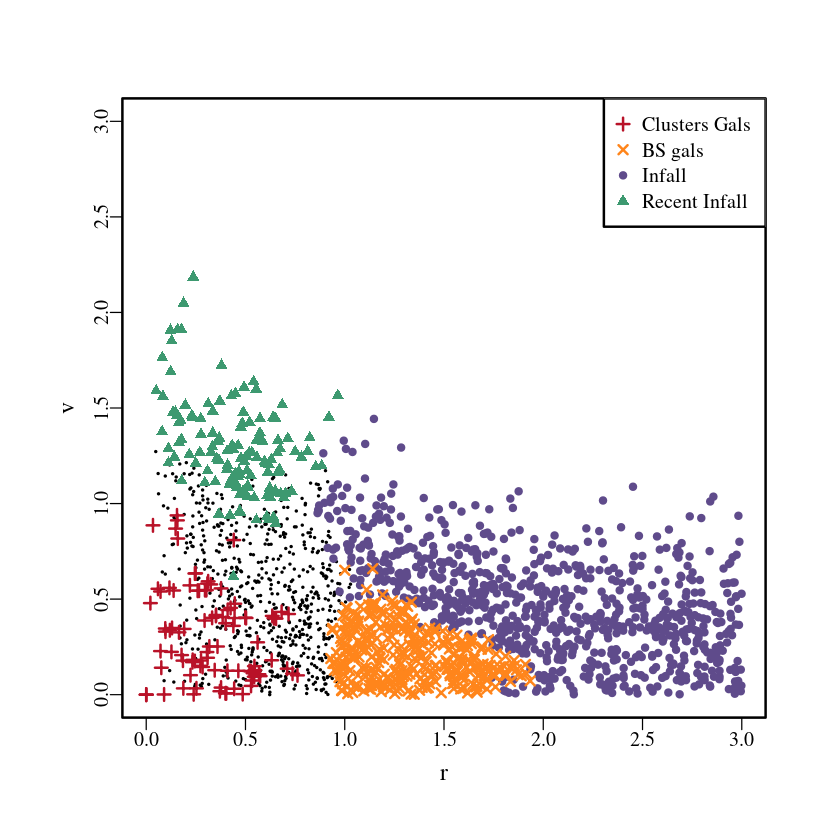

In [17]:
# Let's see the final predictions

par(newpars)
plot(cat$r, cat$v, xlab = 'r', ylab = 'v', xlim = c(0, 3), ylim = c(0, 3), cex = 0.1)
points(cat3$r, cat3$v, col = c3, pch = 20)
points(cat4$r, cat4$v, col = c4, pch = 17)
points(cat2$r, cat2$v, col = c2, pch = 4)
points(cat1$r, cat1$v, col = c1, pch = 3)
legend('topright', c('Clusters Gals', 'BS gals', 'Infall', 'Recent Infall'), col = c(c1, c2, c3, c4), pch = c(3, 4, 20, 17))

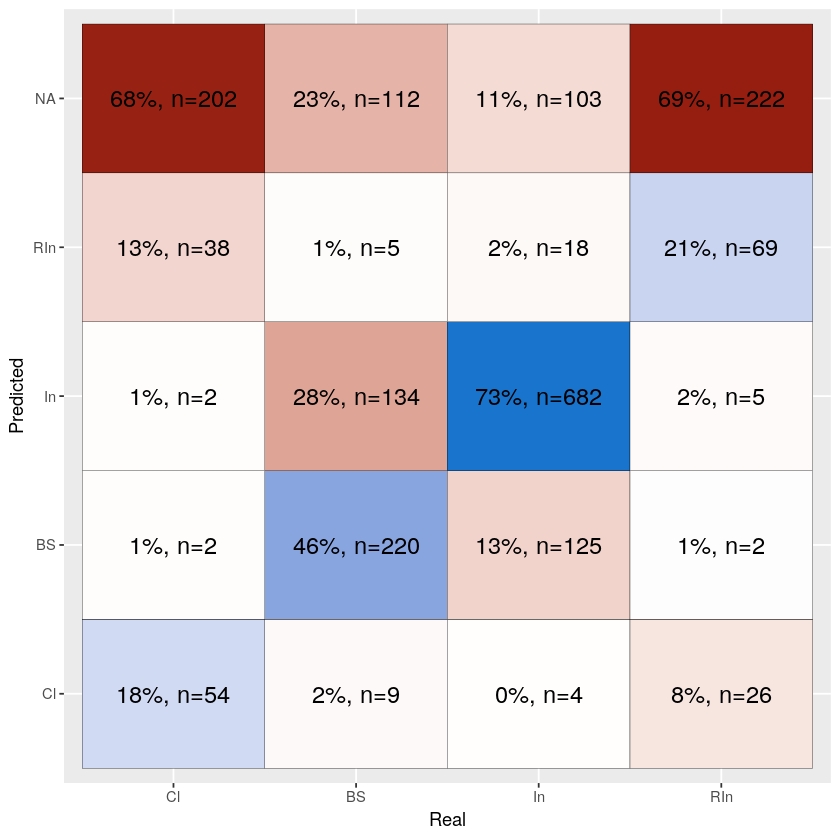

In [76]:
Real            <- cat$real_class
Predict         <- cat$pred_class
levels(Predict) <- c('Cl', 'BS', 'In', 'RIn')
levels(Real)    <- c('Cl', 'BS', 'In', 'RIn')

real_d        <- as.data.frame(table(Real))
names(real_d) <- c("Real", "RealFreq")

# Let's estimate the confusion matrix

cMatrix        <- as.data.frame(table(Real, Predict, useNA = 'ifany'))
names(cMatrix) <- c("Real", "Predicted", "Freq")

cMatrix            <- merge(cMatrix, real_d, by = c('Real', 'Real'))
cMatrix$Percent    <- cMatrix$Freq/cMatrix$RealFreq*100
cMatrix$ColorScale <- cMatrix$Percent*-1
cMatrix[which(cMatrix$Real == cMatrix$Predicted),]$ColorScale <- cMatrix[which(cMatrix$Real == cMatrix$Predicted), ]$ColorScale*-1
cMatrix$Label <- paste(round(cMatrix$Percent,0), "%, n=", cMatrix$Freq, sep = "")

ggplot() +
    geom_tile(aes(x = Real, y = Predicted, fill = ColorScale), data = cMatrix, color = "black", size = 0.1) +
    labs(x = "Real", y = "Predicted") +
    geom_text(aes(x = Real, y = Predicted, label = Label), data = cMatrix, size = 5, colour = "black") +
    scale_fill_gradient2(low = 'red4', high = 'dodgerblue3', mid = 'white', midpoint = 0, guide = 'none')
